In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import lightgbm as lgb
import math
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
path = os.getcwd()
print(path)

/workspace/code


In [5]:
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [ ]:
df_train = pd.read_csv('/workspace/data/train.csv')
df_test =pd.read_csv('/workspace/data/test.csv')
df_sample = pd.read_csv('/workspace/data/sample_submission.csv')

In [7]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


## ランダムフォレス,XGBboost,LightGBMでとりあえず学習(アンサンブル)

### 欠損値補完&特徴量生成  

#### Ageを欠損値補完＆ビニング

In [90]:
# Ageの欠損値を男性、女性の中央値で補完
df_train['Age'].mask(df_train['Age'].isnull() & (df_train['Sex'] == 'male'),df_train[(df_train['Age'].notnull()) & (df_train['Sex'] == 'male')]['Age'].median(),inplace=True)
df_train['Age'].mask(df_train['Age'].isnull() & (df_train['Sex'] == 'female'),df_train[(df_train['Age'].notnull()) & (df_train['Sex'] == 'female')]['Age'].median(),inplace=True)

In [91]:
#  年齢をビニングする値を10ずつ区分け(0~10, 10~20, 20~30・・・80)
df_train['Age_bin'] = pd.cut(df_train['Age'],9,labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89"])

In [92]:
# Age列を削除
df_train = df_train.drop(columns='Age')

In [25]:
# テストデータも同様の処理を行う(ここ関数作るべき)

In [93]:
df_test['Age'].mask(df_test['Age'].isnull() & (df_test['Sex'] == 'male'),df_test[(df_test['Age'].notnull()) & (df_test['Sex'] == 'male')]['Age'].median(),inplace=True)
df_test['Age'].mask(df_test['Age'].isnull() & (df_test['Sex'] == 'female'),df_test[(df_test['Age'].notnull()) & (df_test['Sex'] == 'female')]['Age'].median(),inplace=True)

In [94]:
df_test['Age_bin'] = pd.cut(df_test['Age'],9,labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89"])

In [95]:
df_test = df_test.drop(columns = 'Age')

#### Deckを作成（Cabinの頭文字＝客室がどこら辺にあるかの特徴量を生成) 

In [96]:
def cabin_feat(df, col):
    # 欠損値を「None」に変換
    df[col] = df[col].fillna('None')
    
    # 新しい特徴量を生成
    df[f'has_{col}'] = df[col].apply(lambda x: 1 if x != 'None' else 0)
    df['Deck'] = df[col].apply(lambda x: x[0])
    df.drop(col, axis=1, inplace=True)
    return df

In [97]:
df_train = cabin_feat(df_train, 'Cabin')
df_test = cabin_feat(df_test, 'Cabin')

#### チケット番号の文字を抽出

In [98]:
# 文字列を「空白」で分割する　返り値はリスト型
def str_split(x):
    if len(str(x).split()) > 1:
        # リストの要素数が2より大きい場合は最初の要素を返す
        return str(x).split()[0]
    else: return 'N'

In [99]:
# mapはpandasのSeriesに関数を適用する
df_train['Ticket'] = df_train['Ticket'].map(str_split)
df_test['Ticket'] = df_test['Ticket'].map(str_split)

#### Nameを「,」で分割してlastname(名字)の特徴量を作成

In [100]:
df_train['last_name'] = df_train['Name'].apply(lambda x: x.split(',')[0])
df_test['last_name'] = df_test['Name'].apply(lambda x: x.split(',')[0])

In [101]:
# Name列を削除
df_train = df_train.drop(columns = 'Name')
df_test = df_test.drop(columns = 'Name')

#### Fare_binを作成 Fare(料金をビニング)

In [102]:
#欠損値を中央値で埋める
df_train['Fare']= df_train['Fare'].fillna(df_train['Fare'].median())
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

In [103]:
# 50ドル以下の生存率が低いため下記のような区分でビニングする
def Fare_bin(x):
    if x <=50:
        return 'very low'
    elif  50 < x <= 150:
        return 'low'
    elif 150 < x <= 300:
        return 'middle'
    else:
        return 'high'

In [104]:
df_train['Fare_bin'] = df_train['Fare'].apply(Fare_bin)
df_test['Fare_bin'] = df_test['Fare'].apply(Fare_bin)

In [105]:
df_train = df_train.drop(columns = 'Fare')
df_test = df_test.drop(columns = 'Fare')

#### Family_size　家族の大きさ(何人家族か)の特徴量を作成  
Sibsp + Parch +1(自分)がFamily_size

In [106]:
df_train['Family_Size'] = df_train['SibSp']+df_train['Parch']+1
df_test['Family_Size'] =  df_test['SibSp']+df_test['Parch']+1

In [107]:
# Family_sizeを定義する関数
def family_size(x):
    if x == 1:
        return 'Alone'
    elif  0 < x <= 5:
        return 'small'
    elif  5 < x <= 10:
        return 'middle'
    else:
        return 'large'

In [108]:
df_train['Family_Size'] = df_train['Family_Size'].apply(family_size)
df_test['Family_Size'] = df_test['Family_Size'].apply(family_size)

#### Embarked(出港地)の欠損値を補完(最頻値)

In [55]:
df_train['Embarked'].mode()[0]

'S'

In [109]:
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])
df_test['Embarked'] = df_test['Embarked'].fillna(df_test['Embarked'].mode()[0])

### カテゴリ変数を変換する  
ワンホットエンコーディング:Sex,Embarked,Deck,Age_bin,Fare_bin,Family_size 
ラベルエンコーディング:Ticket,last_name

In [111]:
label_list = ['Ticket', 'last_name','Family_Size']

In [112]:
# ラベルエンコーディング
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

In [113]:
df_train[label_list] = oe.fit_transform(df_train[label_list].values)
df_test[label_list] = oe.fit_transform(df_test[label_list].values)

In [114]:
# ワンホットエンコーディング
dummie_list = ['Sex','Embarked','Age_bin','Deck','Fare_bin']

In [117]:
# 特徴量をダミー変数にする関数
def convert_columns(df, cols):
    
    dummies_df = pd.get_dummies(df[cols], drop_first=True)
    df.drop(cols, axis=1, inplace=True)
    new_df = pd.concat([df, dummies_df], axis=1)
    return new_df

In [118]:
df_train = convert_columns(df_train,dummie_list)
df_test = convert_columns(df_test,dummie_list)

### 欠損値補完、特徴量生成、カテゴリ変数の変換完了

In [124]:
df_train

,PassengerId,Survived,Pclass,SibSp,Parch,Ticket,has_Cabin,last_name,Family_Size,Sex_male,Embarked_Q,Embarked_S,Age_bin_10-19,Age_bin_20-29,Age_bin_30-39,Age_bin_40-49,Age_bin_50-59,Age_bin_60-69,Age_bin_70-79,Age_bin_80-89,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T,Fare_bin_low,Fare_bin_middle,Fare_bin_very low
0,0,1,1,2,0,20.0,1,14195.0,3.0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,0,3,0,0,20.0,0,2495.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2,0,3,1,2,14.0,0,14478.0,3.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,3,0,3,0,0,0.0,0,10435.0,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,4,1,3,0,0,20.0,0,1902.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,0,0,22.0,1,1301.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
99996,99996,0,2,0,0,20.0,0,2436.0,0.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
99997,99997,0,3,0,0,20.0,0,3463.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
99998,99998,0,3,0,1,20.0,0,3226.0,3.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


### 交差検証（Cross-validation)を用いてLightGBMで学習

交差検証(Cross-validation)のイメージ

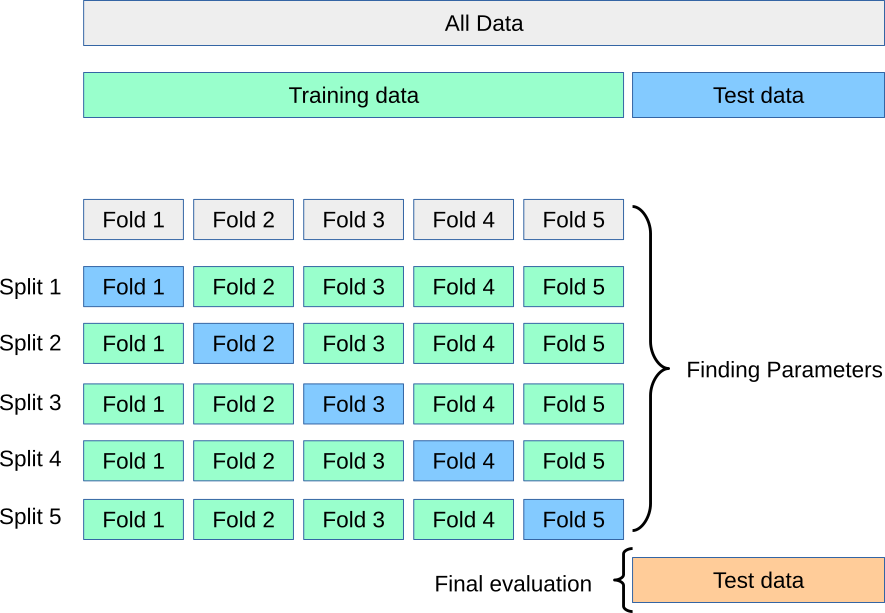

In [143]:
from IPython.display import Image
# 画像ファイル名(パス)
file_name = "20150823195020.png"
# IPythonで画像の読み込みと表示
Image(file_name)

In [129]:
# Passengeridを削除
df_train = df_train.drop(columns='PassengerId')
df_test = df_test.drop(columns='PassengerId')

In [123]:
# 分布に大きな不均衡がある場合に用いるKFold．
# 分布(y=1)の比率を維持したままデータを訓練用とテスト用に分割する．
from sklearn.model_selection import StratifiedKFold

In [147]:
#どのFoldかの列を追加
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
df_train['kfold'] = -1

df_train = df_train.sample(frac=1).reset_index(drop=True)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X=df_train, y=df_train['Survived'])):
    df_train.loc[valid_idx, 'kfold'] = fold

In [162]:
# モデルのトレーニングを行う関数
def run_training(algo, df, df_test, fold, oof):
    #トレーニングデータをValidデータ
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    X_train = df_train.drop(['Survived', 'kfold'], axis=1)
    X_valid = df_valid.drop(['Survived', 'kfold'], axis=1)
    
    #データを標準化
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_valid = sc.transform(X_valid)
    df_test = sc.transform(df_test)
    
    #目的変数を定義
    y_train = df_train['Survived'].values
    y_valid = df_valid['Survived'].values
    
    #モデルを学習
    algo.fit(X_train, y_train)
    
    #学習結果をもとに予測
    preds = algo.predict(X_valid)
    proba = algo.predict_proba(df_test)[:, 1]
    
    fold_acc = accuracy_score(y_valid, preds)
    
    print(f'fold={fold+1}, accuracy={fold_acc}')
    oof[valid_idx] += fold_acc
    
    return oof, proba, algo

##### ランダムフォレストで学習

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

rfc = RandomForestClassifier(n_estimators=150)

df_proba = pd.DataFrame()
test_proba = np.zeros(len(df_test))
oof = np.zeros(len(df_train))
for fold in range(5):
    oof, proba, rfc_model = run_training(rfc,df_train, df_test, fold, oof)
    test_proba += proba
    
df_proba['randomforest'] = test_proba / 5
print(f'Mean accuracy after 5 folds {np.mean(oof)}')

fold=1, accuracy=0.71735
fold=2, accuracy=0.7138
fold=3, accuracy=0.72215
fold=4, accuracy=0.7137
fold=5, accuracy=0.71835
Mean accuracy after 5 folds 0.7170699999999998


#### XGB boostで学習

In [167]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False)

test_proba = np.zeros(len(df_test))
oof = np.zeros(len(df_train))
for fold in range(5):
    oof, proba, xgb_model = run_training(xgb,df_train, df_test, fold, oof)
    test_proba += proba
    
df_proba['xgboost'] = test_proba / 5
print(f'Mean accuracy after 5 folds {np.mean(oof)}')

[15:55:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold=1, accuracy=0.78155
[15:55:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold=2, accuracy=0.7752
[15:55:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold=3, accuracy=0.7784
[15:55:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 

#### Lightgbmで学習

In [168]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

test_proba = np.zeros(len(df_test))
oof = np.zeros(len(df_train))
for fold in range(5):
    oof, proba, lgbm_model = run_training(lgbm,df_train, df_test, fold, oof)
    test_proba += proba
    
df_proba['lgbm'] = test_proba / 5
print(f'Mean accuracy after 5 folds {np.mean(oof)}'')

fold=1, accuracy=0.7848
fold=2, accuracy=0.77815
fold=3, accuracy=0.7816
fold=4, accuracy=0.7776
fold=5, accuracy=0.7843
Mean accuracy after 5 folds 0.78129


In [172]:
# 各モデルの予測値（Survived=1）の確立が入ったdataframe
df_proba

,randomforest,xgboost,lgbm
0,0.004000,0.080496,0.096838
1,0.533467,0.519536,0.548846
2,0.941333,0.902496,0.900221
3,0.295330,0.193759,0.208698
4,0.493333,0.812436,0.787192
...,...,...,...
99995,0.493333,0.718186,0.696257
99996,0.082667,0.114533,0.133424
99997,0.057333,0.109704,0.100294
99998,0.434667,0.623060,0.642874


In [174]:
df_proba['ensemble'] = 0.2 * df_proba['randomforest'] + 0.2 * df_proba['xgboost'] + 0.5 * df_proba['lgbm']
df_proba['ensemble_binary'] = np.where(df_proba['ensemble'] > 0.5, 1, 0)

In [175]:
submission = df_sample.copy()

In [177]:
submission['Survived'] = df_proba['ensemble_binary'].values
submission.to_csv('ensemble_sub.csv',index=False)

In [178]:
submission 

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1
